#Data Exploration and Preprocessing

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler

file_path = 'TASK-ML-INTERN.csv'
data = pd.read_csv(file_path)

data_clean = data.drop('hsi_id', axis=1)
data_clean = data_clean.fillna(data_clean.mean())

for col in data_clean.columns:
    lower = data_clean[col].quantile(0.01)
    upper = data_clean[col].quantile(0.99)
    data_clean[col] = np.clip(data_clean[col], lower, upper)

data_clean['vomitoxin_ppb'], _ = boxcox(data_clean['vomitoxin_ppb'] + 1)


#Feature Scaling and Visualization

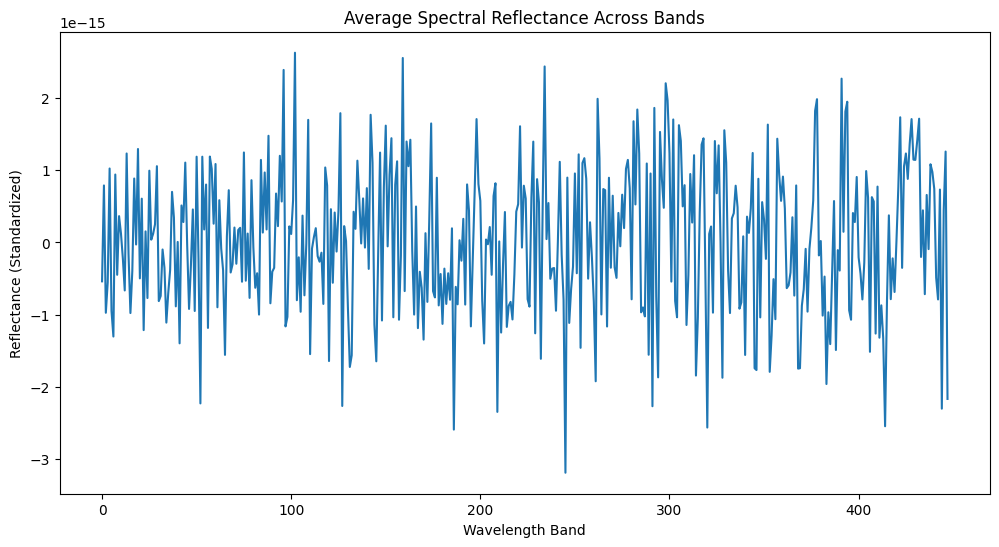

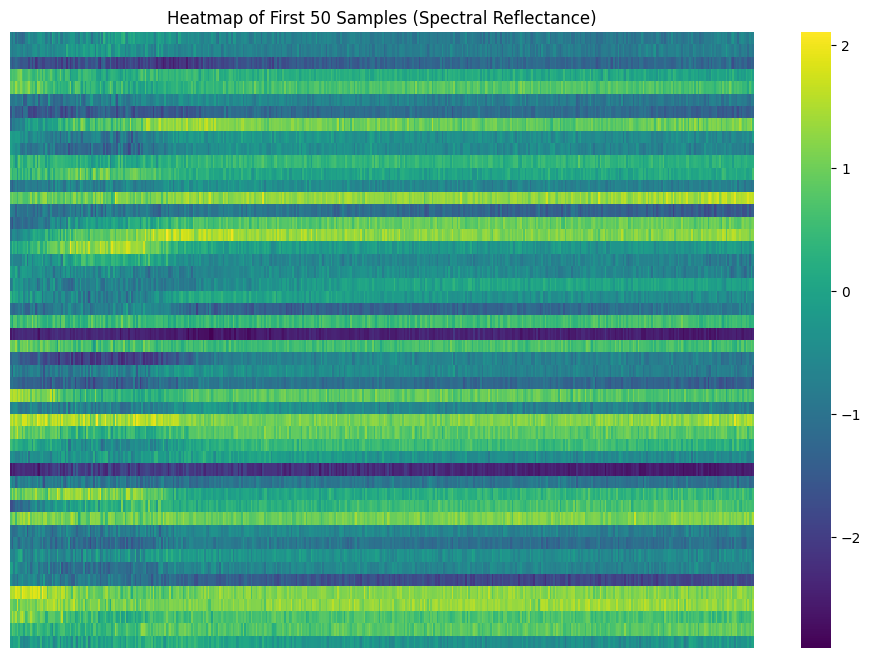

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

X = data_clean.drop('vomitoxin_ppb', axis=1)
y = data_clean['vomitoxin_ppb']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

plt.figure(figsize=(12, 6))
plt.plot(np.mean(X_scaled, axis=0))
plt.title('Average Spectral Reflectance Across Bands')
plt.xlabel('Wavelength Band')
plt.ylabel('Reflectance (Standardized)')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(X_scaled[:50], cmap='viridis', xticklabels=False, yticklabels=False)
plt.title('Heatmap of First 50 Samples (Spectral Reflectance)')
plt.show()


#Dimensionality Reduction

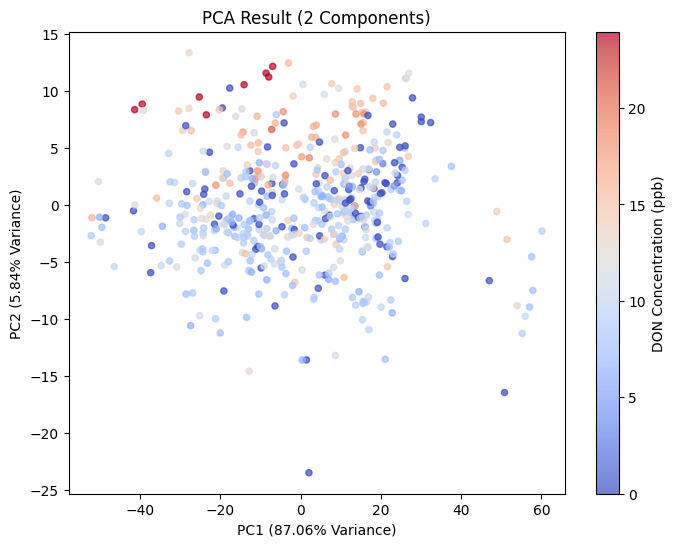

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', s=20, alpha=0.7)
plt.colorbar(label='DON Concentration (ppb)')
plt.title('PCA Result (2 Components)')
plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}% Variance)')
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}% Variance)')
plt.show()

#Model Training

In [4]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBRegressor

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

X_train, X_test, y_train, y_test = train_test_split(X_pca, y_scaled, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [2, 3],
    'learning_rate': [0.005, 0.01],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

model = XGBRegressor(random_state=42)
random_search = RandomizedSearchCV(model, param_distributions=param_grid,
                                   n_iter=5, scoring='neg_mean_squared_error',
                                   cv=3, verbose=1, n_jobs=-1)
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_


Fitting 3 folds for each of 5 candidates, totalling 15 fits


#Model Evaluation

MAE: 3.3643
RMSE: 4.4873
R²: 0.2781


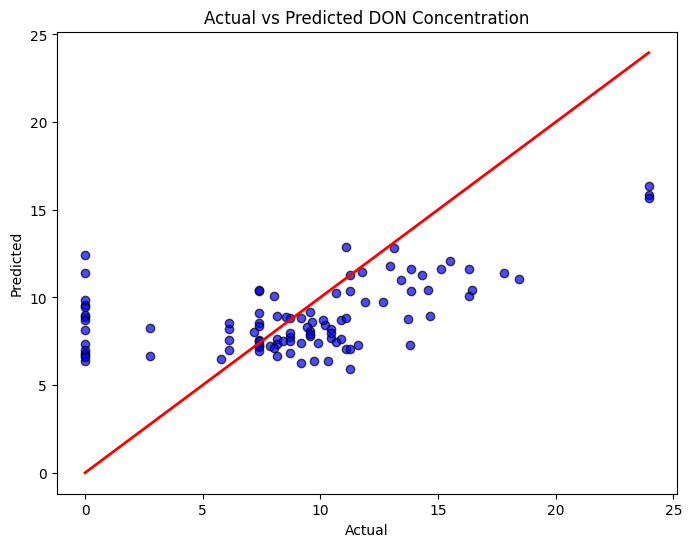

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_scaled = best_model.predict(X_test)

y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test_inv, y_pred_inv, alpha=0.7, color='blue', edgecolors=(0, 0, 0))
plt.plot([min(y_test_inv), max(y_test_inv)], [min(y_test_inv), max(y_test_inv)], color='red', lw=2)
plt.title('Actual vs Predicted DON Concentration')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

#Model Interpretability

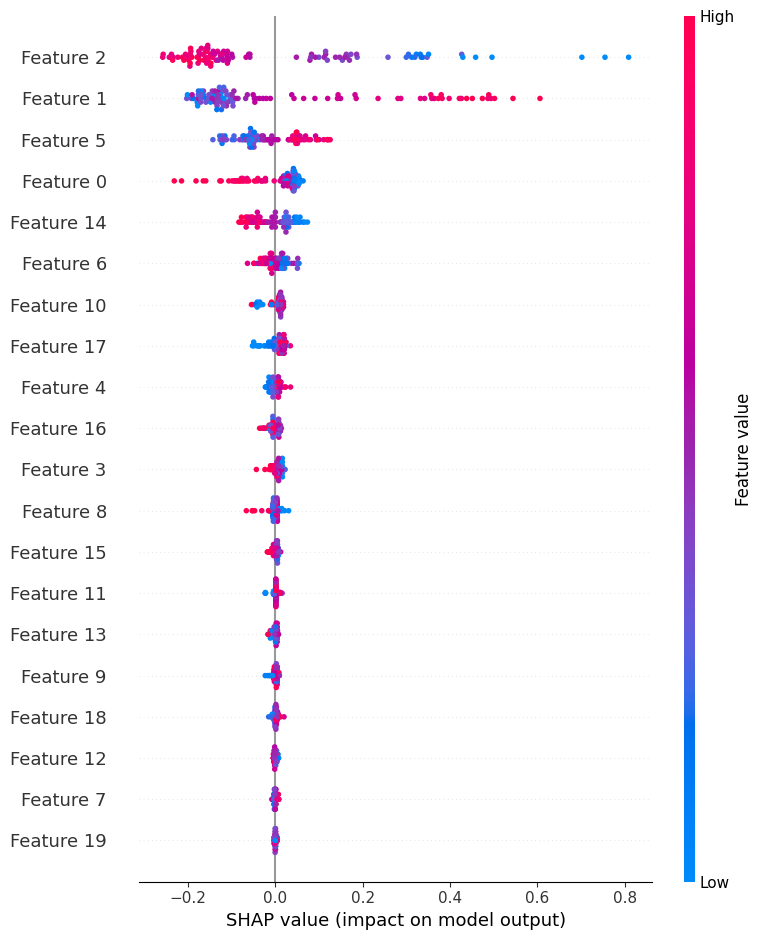

In [6]:
import shap

explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test)
